# ***Setup***

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
print(tf.__version__)

2.14.0


# ***Recognising numbers***

In [2]:
image_number = 0

model = tf.keras.models.load_model('model.h5') 

1/1 [==============================] - 0s 31ms/step


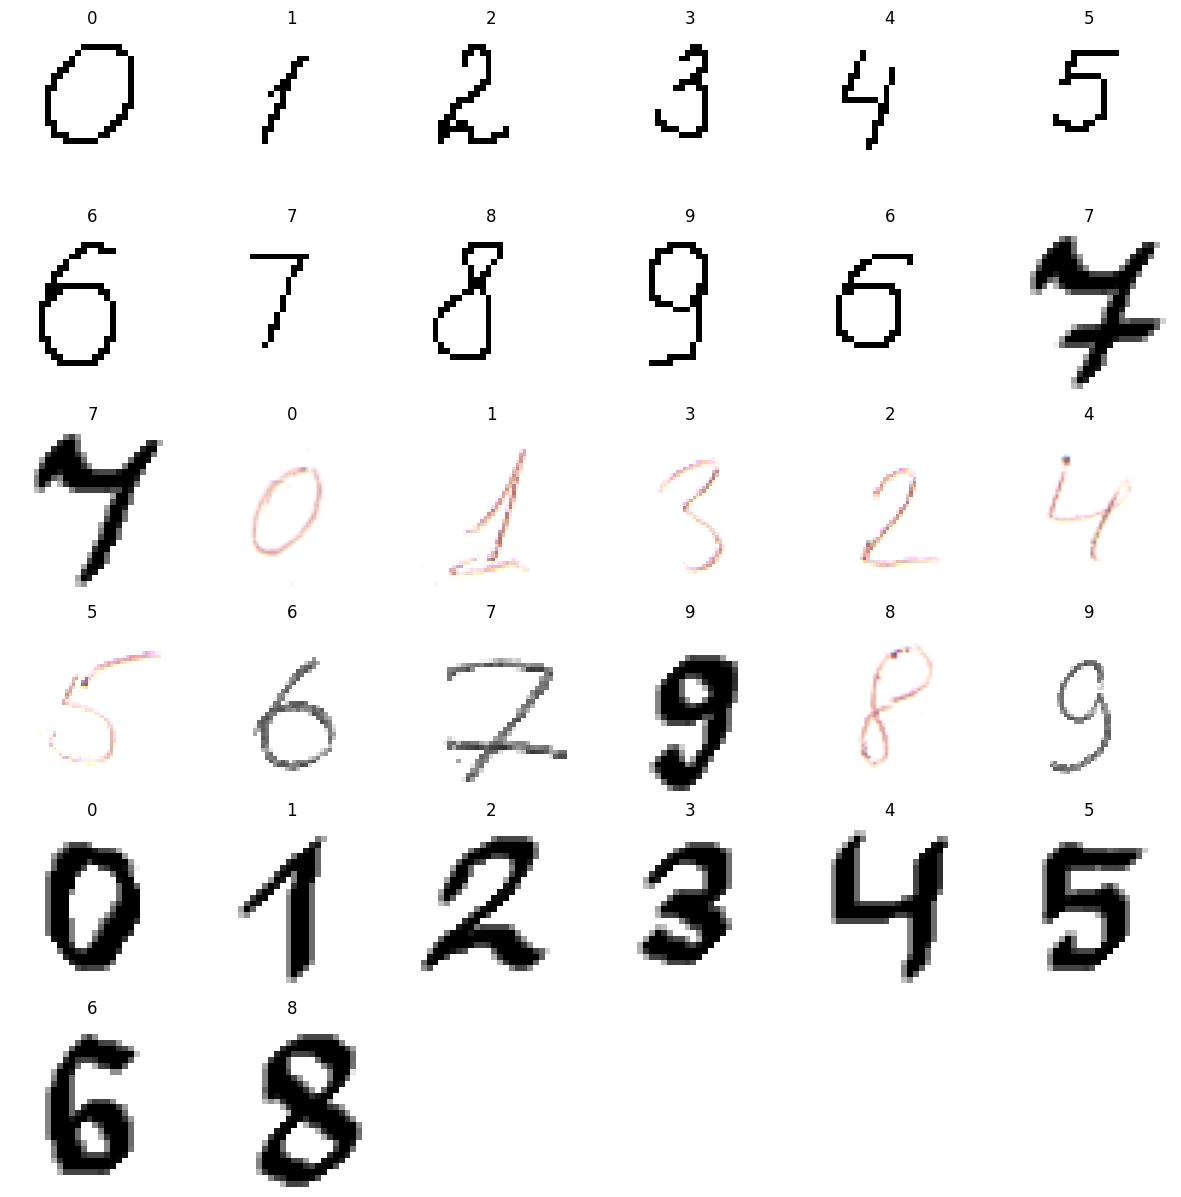

In [3]:
from scipy.ndimage import center_of_mass
import math 
import cv2
import numpy as np

def getBestShift(img):
    cy,cx = center_of_mass(img)
    
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
  
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
    
  
def rec_digit(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  gray = 255-img
  # применяем пороговую обработку
  (thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  
  # удаляем нулевые строки и столбцы
  while np.sum(gray[0]) == 0:
    gray = gray[1:]
  while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)
  while np.sum(gray[-1]) == 0:
    gray = gray[:-1]
  while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)
  rows,cols = gray.shape
  
  # изменяем размер, чтобы помещалось в box 20x20 пикселей
  if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv2.resize(gray, (cols,rows))
  else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv2.resize(gray, (cols, rows))

  # расширяем до размера 28x28
  colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
  rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
  gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

  # сдвигаем центр масс
  shiftx,shifty = getBestShift(gray)
  shifted = shift(gray,shiftx,shifty)
  gray = shifted
  
  # cv2.imwrite('gray'+ img_path, gray)
  img = gray / 255.0
  img = np.array(img).reshape(-1, 28, 28, 1)
  out = str(np.argmax(model.predict(img)))
  return out

images = []
names = []
image_number=0
while os.path.isfile(f"digits/{image_number}.png"):
    try:
        image = cv2.imread(f"digits/{image_number}.png")
        names.append(rec_digit(f"digits/{image_number}.png"))
        images.append(image)
    
    except Exception as e: print(e)
    finally:
         image_number += 1


i = 1
# create figure 
fig = plt.figure(figsize=(15, 15)) 

rows = 6
columns = 6

for img, name in zip(images, names):
# show image 
    plt.style.use('grayscale')
    fig.add_subplot(rows, columns, i) 
    plt.imshow(img) 
    plt.axis('off') 
    plt.title(str(name)) 
    i += 1
    # plt.grid(False) 
    